[*********************100%***********************]  1 of 1 completed


 Final Acceptance Rate(Post-adaptation): 0.96


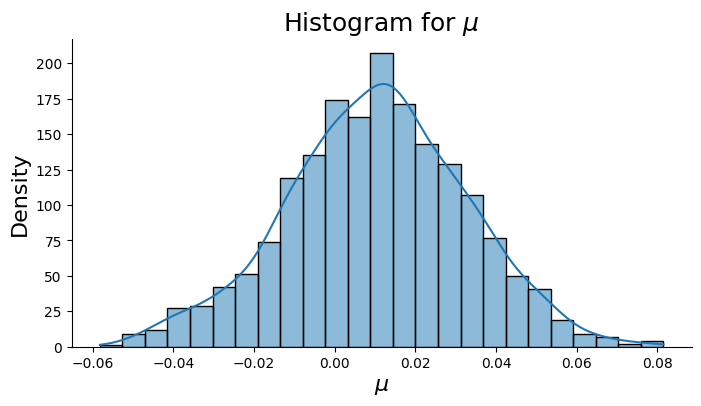

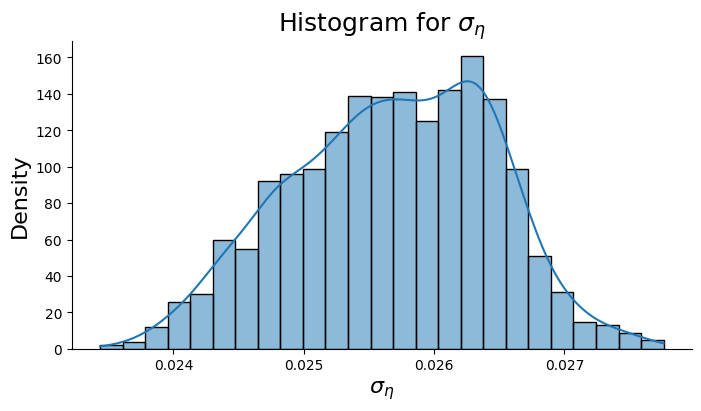

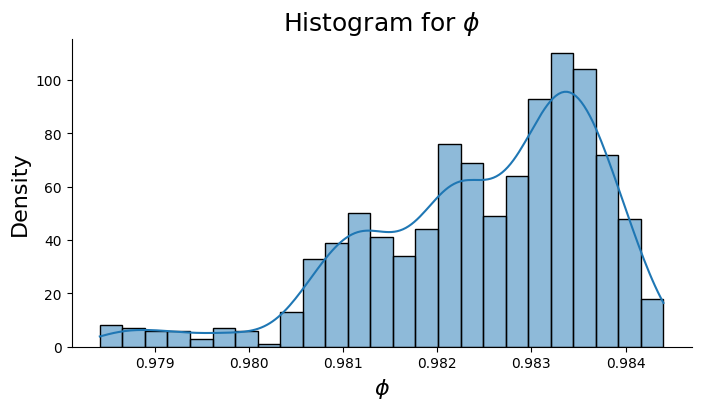

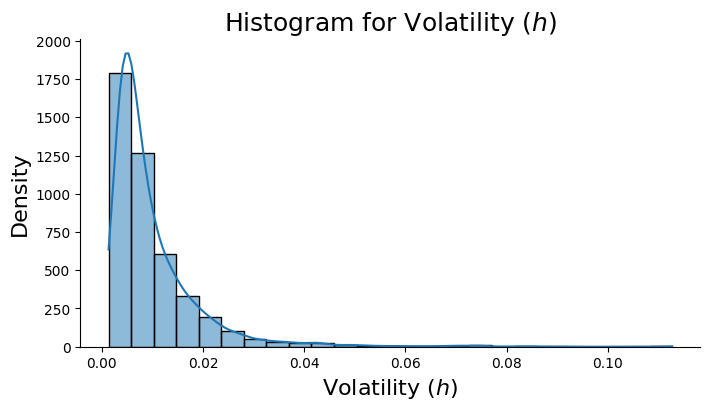

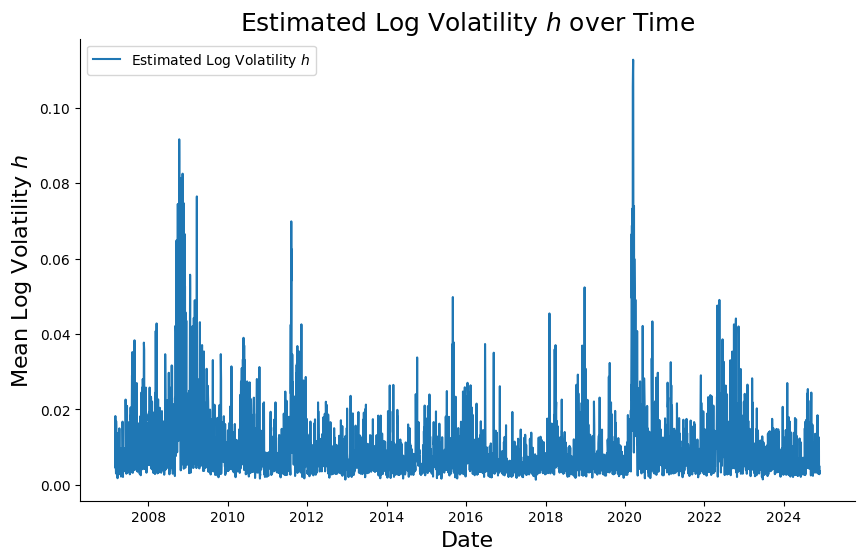

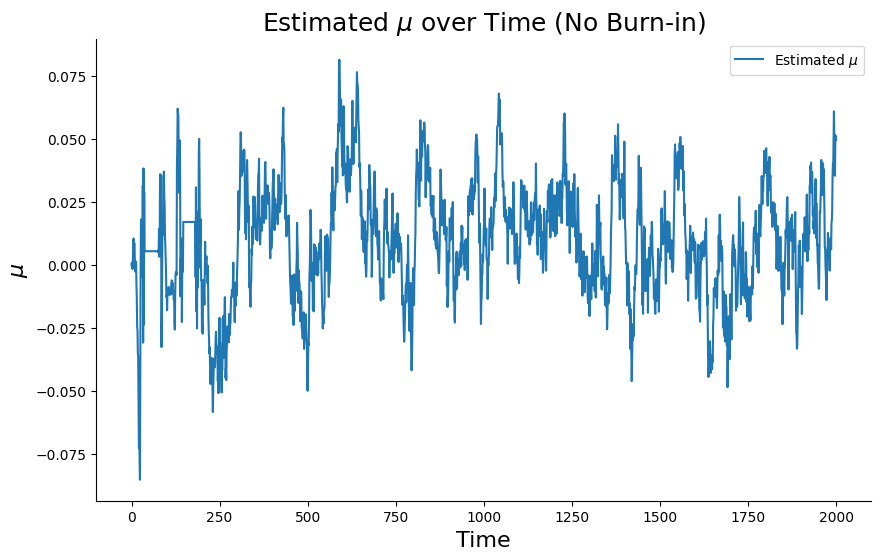

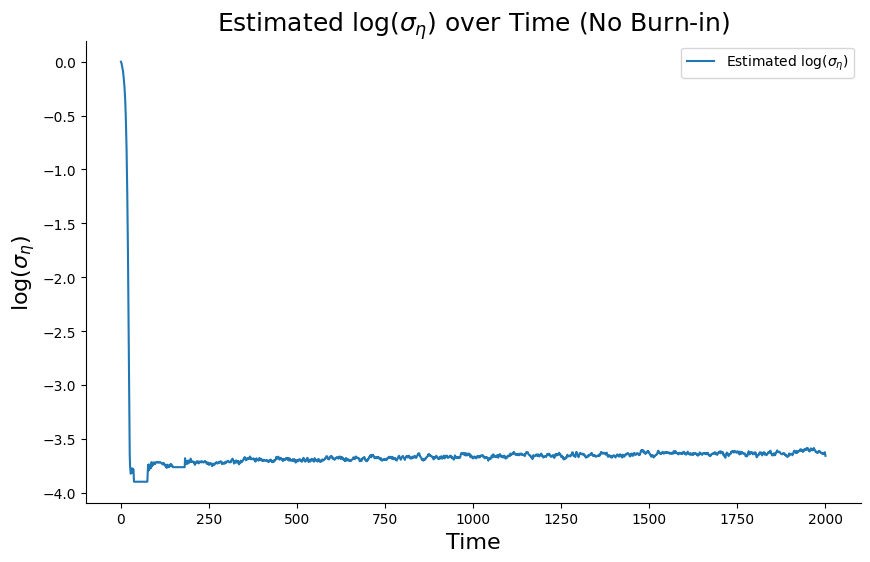

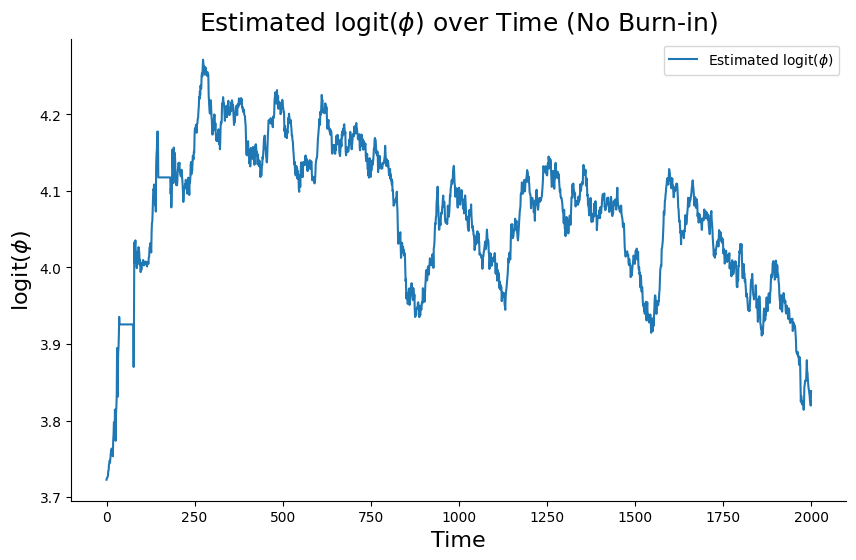

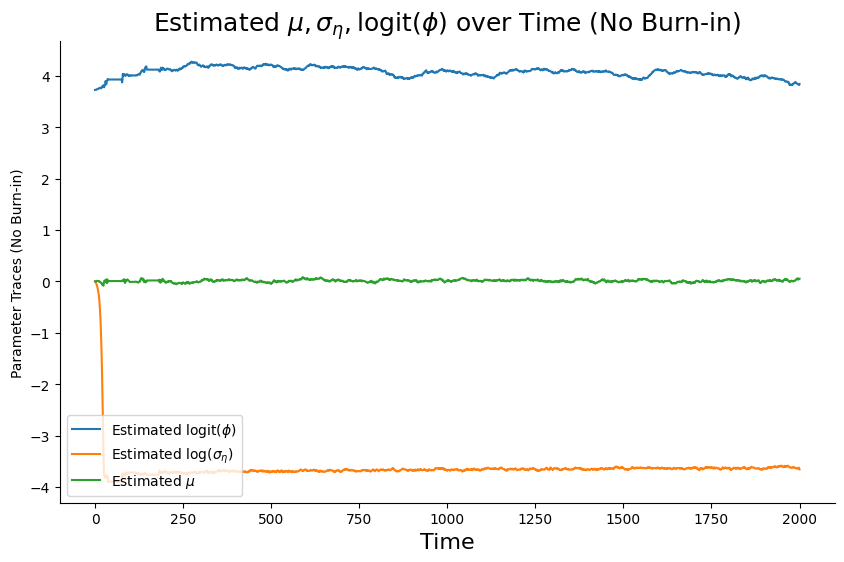

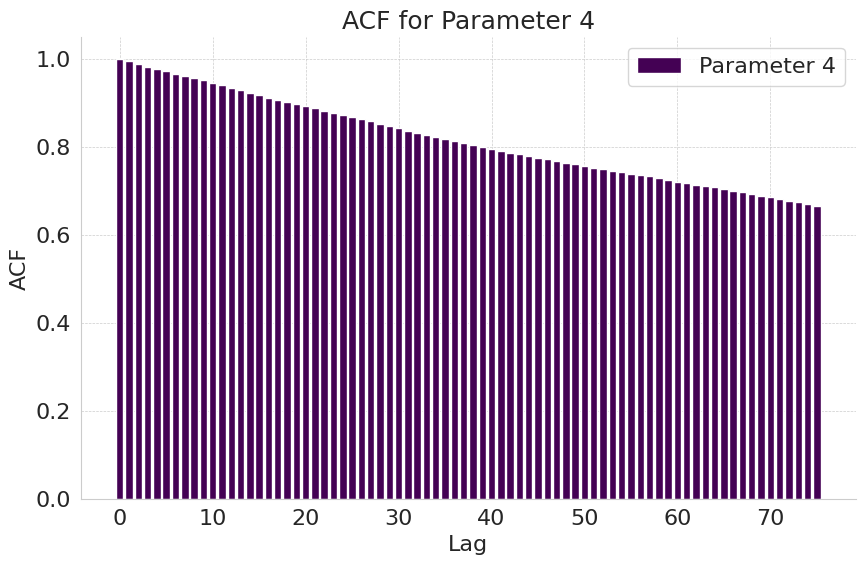

Mean Mu, Var Mu = tensor(0.0098) tensor(0.0005)
Mean Sigma_eta, Var Sigma_eta = tensor(0.0327) tensor(0.0055)
Mean Phi, Var Phi = tensor(0.9831) tensor(2.6786e-06)
Mean h, Var h = tensor(0.0073) tensor(7.3366e-05)


  4%|▍         | 1/25 [00:16<06:25, 16.05s/it]

 Final Acceptance Rate(Post-adaptation): 0.91


  8%|▊         | 2/25 [00:32<06:09, 16.05s/it]

 Final Acceptance Rate(Post-adaptation): 0.93


 12%|█▏        | 3/25 [00:48<05:52, 16.03s/it]

 Final Acceptance Rate(Post-adaptation): 0.13
Run 3 discarded, acceptance rate 0.13


 16%|█▌        | 4/25 [01:04<05:36, 16.02s/it]

 Final Acceptance Rate(Post-adaptation): 0.13
Run 4 discarded, acceptance rate 0.13


 16%|█▌        | 4/25 [01:04<05:40, 16.23s/it]


ValueError: Expected parameter loc (Tensor of shape (4465,)) of distribution Normal(loc: torch.Size([4465]), scale: torch.Size([4465])) to satisfy the constraint Real(), but found invalid values:
tensor([13736.3594, 13736.3594, 13736.3594,  ..., 13736.3594, 13736.3594,
        13736.3594], grad_fn=<AddBackward0>)

In [1]:
import yfinance as yf
import torch
import torch.distributions as dist
from torch.autograd import grad
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import acf
import random
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
random.seed(45)
# Used to avoid log(0) KABOOM
EPS = 1e-12

# Download S&P 500 stock data starting in March 2007
SP_data_full = yf.download(tickers='^GSPC', period='max', interval='1d')
start_date = '2007-03-01'
SP_data = SP_data_full.loc[start_date:].copy()  
SP_data['Log_Return'] = np.log(SP_data['Close']).diff()
SP_data['Diff_Log_Return'] = SP_data['Log_Return'].diff()
SP_data = SP_data.dropna()
data = torch.tensor(SP_data['Diff_Log_Return'].values, dtype=torch.float64)

# Function to define the model's likelihood
def log_likelihood(data, log_h, mu, log_sigma_eta, logit_phi):
    sigma_eta = torch.exp(log_sigma_eta).abs() + EPS
    phi = logit_phi_to_phi(logit_phi)  
    T = data.size(0)
    obs_ll = dist.Normal(0, torch.exp(log_h).clamp_min(1e-8) / 2).log_prob(data).sum()
    trans_ll = dist.Normal(mu + phi * (torch.exp(log_h[:-1]) - mu), sigma_eta).log_prob(torch.exp(log_h[1:])).sum()
    return obs_ll + trans_ll

def safe_log(x):
    return torch.log(x.clamp_min(1e-12))

def logit_phi_to_phi(logit_phi):
    return (torch.tanh(logit_phi/2) + 1)/2 

# InverseGamma change to be "stretched"
def invgamma_log_prob(x, concentration, scale):
    rate = (concentration / scale).clamp_min(EPS)
    ig = dist.InverseGamma(concentration, rate)
    return ig.log_prob(x)

def log_prior(mu, log_sigma_eta, logit_phi):
    mu_prior = dist.Normal(0, torch.sqrt(torch.tensor(10.0)))
    log_prior_mu = mu_prior.log_prob(mu)
    sigma_eta = torch.exp(log_sigma_eta)

    log_prior_sigma_eta = invgamma_log_prob(sigma_eta, torch.tensor(5.0/2), torch.tensor(0.01*5/2)) + log_sigma_eta

    phi = logit_phi_to_phi(logit_phi)  # Use reparameterized phi
    phi_star = (phi + 1) / 2  # Convert phi to [0,1] for Beta distribution adjustment
    phi_star_prior = dist.Beta(torch.tensor(20.0), torch.tensor(1.5))
    log_prior_phi = phi_star_prior.log_prob(phi_star) + safe_log(1 - phi_star.pow(2)) # if phi_star near one, we may end up taking log(0) -> just take log(EPS)

    return log_prior_mu + log_prior_sigma_eta + log_prior_phi

# Combined log-posterior function
def log_posterior(theta, data):
    mu, log_sigma_eta, logit_phi = theta[:3]
    log_h = theta[3:]
    return log_likelihood(data, log_h, mu, log_sigma_eta, logit_phi) + log_prior(mu, log_sigma_eta, logit_phi)

# Leapfrog integrator for HMC
def leapfrog(theta, momentum, step_size, data):
    grads_val = get_grad_log_posterior(theta, data)
    momentum = momentum + 0.5 * step_size * grads_val
    theta = theta + step_size * momentum
    grads_val = get_grad_log_posterior(theta, data)
    momentum = momentum + 0.5 * step_size * grads_val
    return theta, momentum

# Gradient of log-posterior
def get_grad_log_posterior(theta, data):
    theta = theta.clone().detach().requires_grad_(True)
    posterior_val = log_posterior(theta, data)
    posterior_grad = grad(posterior_val, theta)[0]
    noise_scale = 1e-8  # scale of the Gaussian noise
    gradient_noise = torch.randn(posterior_grad.size()) * noise_scale
    posterior_grad += gradient_noise
    return posterior_grad.detach()

def hmc_adaptive(data, initial_params, step_size, num_leapfrog_steps, num_samples, warmup_steps):
    samples = [initial_params]
    momentum_dist = dist.Normal(0.0, 1.0)
    accepted = 0
    target_acceptance_rate = 0.65

    for i in range(num_samples):
        theta = samples[-1].clone().detach().requires_grad_()
        momentum = momentum_dist.sample(theta.shape)
        momentum_old = momentum.clone()

        # leapfrog integration
        for _ in range(num_leapfrog_steps):
            theta, momentum = leapfrog(theta, momentum, step_size, data)

        # Hamiltonian calculation
        pot_energy_new = -log_posterior(theta, data)
        kin_energy_new = 0.5 * momentum.pow(2).sum()
        pot_energy_old = -log_posterior(samples[-1], data)
        kin_energy_old = 0.5 * momentum_old.pow(2).sum()

        # Acceptance step
        if torch.rand(1) < torch.exp(pot_energy_old - pot_energy_new + kin_energy_old - kin_energy_new):
            samples.append(theta.detach())
            accepted += 1
        else:
            samples.append(samples[-1])

        # Warm-up and adaptation
        if i < warmup_steps:
            acceptance_rate = accepted / (i + 1)
            if acceptance_rate < target_acceptance_rate:
                step_size *= 0.9
            else:
                step_size *= 1.1

    acceptance_rate = accepted / num_samples
    print(f' Final Acceptance Rate(Post-adaptation): {acceptance_rate:.2f}')
    
    return torch.stack(samples), acceptance_rate

#---------------
# Configuration:
#---------------

# Initial guesses:
initial_mu = torch.tensor(0.0)
initial_log_sigma_eta = torch.log(torch.tensor(1.0))  
initial_phi_star = dist.Beta(torch.tensor(20.0), torch.tensor(1.5)).sample()
initial_logit_phi = torch.log(initial_phi_star / (1 - initial_phi_star)) 
initial_h_value = torch.log(torch.tensor(0.0036))
initial_h = torch.full((data.size(0),), initial_h_value)  

initial_params = torch.cat([torch.stack([initial_mu, initial_log_sigma_eta, initial_logit_phi]), initial_h])

# HMC parameters
step_size = 0.001
num_leapfrog_steps = 2
num_samples = 2000 # increase to 10k get better histograms more consistently
warmup_steps = 200

# Compute HMC sample
# sig is on log scale and phi on logit  
samples, acceptance_rate = hmc_adaptive(data, initial_params, step_size, num_leapfrog_steps, num_samples, warmup_steps)

#--------------
# Diagnostics:
#--------------

def check_multimodality(samples):
    # Extract parameter samples for mu, log_sigma_eta, and
    #  logit_phi
    mu_samples = samples[:, 0]
    log_sigma_eta_samples = samples[:, 1]
    logit_phi_samples = samples[800:, 2]
    sigma_eta_samples = torch.exp(log_sigma_eta_samples)
    phi_samples = logit_phi_to_phi(logit_phi_samples)  

    h_samples = samples[:, 3:]
    mean_h = torch.exp(h_samples).mean(dim=0) 

    parameters = {
        r'$\mu$': mu_samples,
        r'$\sigma_{\eta}$': sigma_eta_samples,
        r'$\phi$': phi_samples,
        r'Volatility ($h$)': mean_h
    }

    for name, values in parameters.items():
        plt.figure(figsize=(8, 4))
        sns.histplot(values.numpy(), kde=True, bins=25)  
        plt.title(f'Histogram for {name}', fontsize=18)
        plt.xlabel(name, fontsize=16)
        plt.ylabel('Density', fontsize=16)
        sns.despine()
        plt.show()

check_multimodality(samples[200:,])

def plot_volatility_h(samples, burn_in, data_dates):
    h_samples = samples[burn_in:, 3:] 
    mean_h = torch.exp(h_samples).mean(dim=0) 
    aligned_dates = data_dates[-mean_h.size(0):]

    plt.figure(figsize=(10, 6))
    plt.plot(aligned_dates, mean_h.numpy(), label='Estimated Log Volatility $h$')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Mean Log Volatility $h$', fontsize=16)
    plt.title('Estimated Log Volatility $h$ over Time', fontsize=18)
    plt.legend()
    sns.despine()
    plt.show()

# Now call the plot function with the correct arguments
data_dates = SP_data.index  # Assuming SP_data.index has the correct DateTimeIndex
plot_volatility_h(samples, 200, data_dates)


def plot_trace(samples, burn_in=0):
    mu_samples = samples[burn_in:, 0]
    sig_eta_samples = samples[burn_in:, 1]
    phi_samples = samples[burn_in:, 2]

    # Plot trace for mu
    plt.figure(figsize=(10, 6))
    plt.plot(mu_samples, label=r'$\text{Estimated }\mu$')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel(r'$\mu$', fontsize=16)
    plt.title(r'$\text{Estimated } \mu \text{ over Time (No Burn-in)}$', fontsize=18)
    plt.legend()
    sns.despine()
    plt.show()

    # sigma_eta
    plt.figure(figsize=(10, 6))
    plt.plot(sig_eta_samples, label=r'$\text{Estimated } \log(\sigma_\eta)$')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel(r'$\log(\sigma_\eta)$', fontsize=16)
    plt.title(r'$\text{Estimated } \log(\sigma_\eta) \text{ over Time (No Burn-in)}$', fontsize=18)
    plt.legend()
    sns.despine()
    plt.show()

    # phi
    plt.figure(figsize=(10, 6))
    plt.plot(phi_samples, label=r'$\text{Estimated logit}(\phi$)')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel(r'$\text{logit}(\phi)$', fontsize=16)
    plt.title(r'$\text{Estimated } \text{logit}(\phi) \text{ over Time (No Burn-in)}$', fontsize=18)
    plt.legend()
    sns.despine()
    plt.show()

    # combined trace
    plt.figure(figsize=(10, 6))
    plt.plot(phi_samples, label=r'$\text{Estimated logit}(\phi$)')
    plt.plot(sig_eta_samples, label=r'$\text{Estimated } \log(\sigma_\eta)$')
    plt.plot(mu_samples, label=r'$\text{Estimated }\mu$')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Parameter Traces (No Burn-in)')
    plt.title(r'$\text{Estimated } \mu, \sigma_\eta,\text{logit}(\phi) \text{ over Time (No Burn-in)}$', fontsize=18)
    plt.legend()
    sns.despine()
    plt.show()

plot_trace(samples, burn_in=0)


def plot_acf_custom(samples, lags, parameter_index, burnin=200):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 16})

    if 0 <= parameter_index < samples.shape[1]:
 
        if isinstance(samples, torch.Tensor):
            samples = samples.numpy()
        acf_vals = acf(samples[burnin:, parameter_index], nlags=lags, fft=True)
        colormap = plt.get_cmap('viridis')
        col = colormap(parameter_index / samples.shape[1])

        plt.bar(np.arange(lags + 1), acf_vals, color=col, label=f'Parameter {parameter_index + 1}')
        plt.xlabel('Lag', fontsize = 16)
        plt.ylabel('ACF', fontsize = 16)
        plt.title(f'ACF for Parameter {parameter_index + 1}', fontsize=18)
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.axhline(0, color='black', linewidth=0.7, linestyle='--')
        sns.despine()  
        plt.show()
    else:
        print('Invalid Argument: parameter_index is out of range.')

plot_acf_custom(samples, lags=75, parameter_index=3, burnin=200)

#Sample statistics from one run of HMC
print("Mean Mu, Var Mu =", torch.mean(samples[:,0]), torch.var(samples[:,0]))
print("Mean Sigma_eta, Var Sigma_eta =", torch.mean(torch.exp(samples[:,1])), torch.var(torch.exp(samples[:,1])))
print("Mean Phi, Var Phi =", torch.mean(logit_phi_to_phi(samples[:,2])), torch.var(logit_phi_to_phi(samples[:,2])))
print("Mean h, Var h =", torch.exp(torch.mean(samples[:,3:])), torch.var(torch.exp(torch.mean(samples[:,3:], dim=0)), dim=0))

# Function to run HMC many times and combine results 
def run_hmc_sampler(num_runs, data, step_size, num_leapfrog_steps, num_samples, warmup_steps, target_acceptance_rate=0.6):
    param_means = []
    param_vars = []
    param_final = []
    samples_pb = []
    acceptance_rates = []
    prior_mu = np.random.normal(0,1,num_runs)
    prior_s =  1/np.random.gamma(2.5,1/.025,num_runs)
    prior_p = np.random.beta(20,1.5,num_runs)

    for run in tqdm(range(num_runs)):
        m = prior_mu[run]
        s = prior_s[run]
        p = prior_p[run]
        initial_mu = torch.tensor(0.0)
        initial_log_sigma_eta = torch.log(torch.tensor(1.0))  
        initial_phi_star = dist.Beta(torch.tensor(20.0), torch.tensor(1.5)).sample()
        initial_logit_phi = torch.log(initial_phi_star / (1 - initial_phi_star)) 
        initial_h_value = torch.log(torch.tensor(0.0036))
        initial_h = torch.full((data.size(0),), initial_h_value)  

        initial_params = torch.cat([torch.stack([initial_mu, initial_log_sigma_eta, initial_logit_phi]), initial_h])
        samples, acceptance_rate = hmc_adaptive(
            data, 
            initial_params, 
            step_size, 
            num_leapfrog_steps, 
            num_samples, 
            warmup_steps
        )
        
        # Check if the acceptance rate is higher than target_acceptance_rate
        if acceptance_rate >= target_acceptance_rate:
            acceptance_rates.append(acceptance_rate)
            
            
            mu_samples = samples[:, 0]
            sigma_eta_samples = torch.exp(samples[:, 1])
            phi_samples = logit_phi_to_phi(samples[:, 2])
            h_samples = samples[:, 3:]

            
            mean_mu = torch.mean(mu_samples)
            mean_sigma_eta = torch.mean(sigma_eta_samples)
            mean_phi = torch.mean(phi_samples)
            mean_h = torch.exp(torch.mean(h_samples))
        

            var_mu = torch.var(mu_samples)
            var_sigma_eta = torch.var(sigma_eta_samples)
            var_phi = torch.var(phi_samples)
            var_h = torch.var(torch.exp(torch.mean(h_samples, dim=0)), dim=0)
        
            
            param_means.append(torch.tensor([mean_mu, mean_sigma_eta, mean_phi, mean_h]))
            param_vars.append(torch.tensor([var_mu, var_sigma_eta, var_phi, var_h]))
            param_final.append(torch.tensor([mu_samples[-1], sigma_eta_samples[-1], phi_samples[-1]]))
            samples_pb.append(h_samples)
        else:
            print(f"Run {run + 1} discarded, acceptance rate {acceptance_rate:.2f}")

    # Calculate the overall mean and variance across runs for each parameter
    overall_means = torch.stack(param_means).mean(dim=0)
    overall_vars = torch.stack(param_vars).mean(dim=0)

    return overall_means, overall_vars, param_final, samples_pb, prior_mu,prior_s,prior_p,acceptance_rates

# HMC configuration
num_runs = 25

# Run the HMC sampler 100 times and get the mean and variance for each parameter
#Multiple samples plus prior parameters are used for SBC
overall_means, overall_vars, params , samples_pb, prior_m,prior_s,prior_p,acceptance_rates = run_hmc_sampler(
    num_runs, 
    data, 
    step_size, 
    num_leapfrog_steps, 
    1000, 
    warmup_steps
)

# Print the results for mu, sigma_eta, phi, and h
print("Overall mean and variance for μ:", overall_means[0], overall_vars[0])
print("Overall mean and variance for σ_η:", overall_means[1], overall_vars[1])
print("Overall mean and variance for φ:", overall_means[2], overall_vars[2])
print("Overall mean and variance for h (averaged over all h):", overall_means[3], overall_vars[3])
print("Mean Acceptance rate (for runs above target):", np.mean(acceptance_rates)) 


In [ ]:

# Simulation Based Calibration Diagnostic
def SBC(samples,prior_m,prior_s,prior_p):
    ranks = []
    momentum_dist = dist.Normal(0, 1)
    for k in tqdm(range(len(samples))):
        theta = torch.cat((torch.tensor([prior_m[k],prior_s[k],prior_p[k]]), samples[k][-1])).clone().detach().requires_grad_()
        momentum =  momentum_dist.sample(theta.shape)

        theta_r = theta.clone().detach()
        # leapfrog integration
        r = [0,0,0]
        for m in range(20):
            mom_r =  momentum_dist.sample(theta.shape)
            t = theta_r.clone().detach()
            for _ in range(num_leapfrog_steps):
                t, mom_r = leapfrog(t, mom_r, step_size, data)
            
            for j in range(3):
                r[j] = r[j] + 1 if t[j] < theta[j] else r[j]
        ranks.append(r)
    ranks = np.array(ranks)
    return ranks

ranks = SBC(samples_pb,prior_m,prior_s,prior_p)

plt.figure(figsize=(8, 4))
sns.histplot(ranks[:,0], kde=True, bins=20)  
plt.title('Histogram for mu')
plt.xlabel('rank')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(ranks[:,1], kde=True, bins=20)  
plt.title('Histogram for sigma')
plt.xlabel('rank')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(ranks[:,2], kde=True, bins=20)  
plt.title('Histogram for phi')
plt.xlabel('rank')
plt.ylabel('Density')
plt.show()

#Rhat
#Values less than 1.1 are considered good

N = len(samples[1])

M = len(samples)

vars = torch.tensor([torch.var(h,dim=0) for h in samples])
means = torch.tensor([torch.mean(h,dim=0) for h in samples])
W = torch.mean(vars).item()
B = (torch.var(means)*(N -1)).item()
rhat = (((N/(N-1))*W + (1/N)*B)/W)**(1/2)
print('Rhat =', rhat)


#Calculate average Effective sample size across each of the parameters in the chain
ESS = []
for n in tqdm(range(N)):
    h_sample = samples[:,n]
    p_t = acf(h_sample, nlags=M, fft=True)
    for t in range(len(p_t)):
        p_t[t] = ((M-t)/M) * p_t[t]
        if p_t[t] < 0:
            p_t = p_t[:t-1]
            break

    ESS.append((M)/(2*np.sum(p_t) + 1))

print('ESS =', np.mean(ESS))